In [1]:
# Custom codes are used for this study.

# Import the libraries

In [2]:
import rdkit
import pandas as pd
import sys
import math
import collections
from math import log
from scipy import stats
from rdkit import Chem, DataStructs
import numpy as np
import seaborn as sns #pip install seaborn
import matplotlib #pip install matplotlib
import matplotlib.pyplot as plt
import sklearn #pip install scikit-learn
from sklearn.decomposition import PCA
from collections import Counter # count freq
from operator import itemgetter
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from matplotlib_venn import venn2
from matplotlib_venn import venn2_unweighted  
from matplotlib import gridspec
import matplotlib.backend_tools as mpt
from matplotlib.offsetbox import OffsetImage,AnnotationBbox,TextArea
import matplotlib.backend_tools as mpt
import matplotlib.backends
from tqdm import tqdm
import numpy
from scipy.cluster.hierarchy import dendrogram, linkage

In [3]:
from matplotlib.offsetbox import OffsetImage,AnnotationBbox,TextArea
import pylab
from pylab import xticks
from mpl_toolkits import mplot3d
from matplotlib import (
    _api, backend_tools as tools, cbook, colors, text,
    transforms, widgets, get_backend, is_interactive, rcParams)
import matplotlib_tools as mpt
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
# pip install lazypredict-nightly yaparak sorun çozuldu
import lazypredict
import lazypredict.Supervised
from lazypredict.Supervised import LazyClassifier
from lazypredict.Supervised import LazyRegressor
from sklearn.utils import all_estimators
from sklearn.model_selection import train_test_split
import glob
import random
import base64
import pandas as pd

from PIL import Image
from io import BytesIO
from IPython.display import HTML

In [4]:
from rdkit.Chem import rdDepictor
rdDepictor.SetPreferCoordGen(True)

In [5]:
print("User Current Version:-", sys.version)

User Current Version:- 3.12.8 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:48:34) [MSC v.1929 64 bit (AMD64)]


# Import Porphyrin Dataset 

In [6]:
porph = pd.read_csv('porphyrin.csv')
porph.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value
0,CHEMBL1325592,PROTOPORPHYRIN,-1.00,562.67,2.00,7.50,SID50106857,C=CC1=C(C)c2cc3[nH]c(cc4nc(cc5[nH]c(cc1n2)c(C)...,Potency,'=',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CHEMBL441738,AFAMELANOTIDE,4.00,1646.87,NaN,NaN,NDP-MSH,CCCC[C@H](NC(=O)[C@H](CO)NC(=O)[C@H](Cc1ccc(O)...,EC50,'=',...,SINGLE PROTEIN,CHEMBL1136069,1.00,Scientific Literature,Bioorg Med Chem Lett,2003.00,CHEMBL3307715,NaN,NaN,NaN
2,CHEMBL441738,AFAMELANOTIDE,4.00,1646.87,NaN,NaN,NDP-MSH,CCCC[C@H](NC(=O)[C@H](CO)NC(=O)[C@H](Cc1ccc(O)...,EC50,'=',...,SINGLE PROTEIN,CHEMBL1136069,1.00,Scientific Literature,Bioorg Med Chem Lett,2003.00,CHEMBL3307715,NaN,NaN,NaN
3,CHEMBL71,CHLORPROMAZINE,4.00,318.87,0.00,4.89,Chlorpromazine,CN(C)CCCN1c2ccccc2Sc2ccc(Cl)cc21,IC50,'=',...,SINGLE PROTEIN,CHEMBL1136167,1.00,Scientific Literature,Bioorg Med Chem Lett,2003.00,NaN,NaN,NaN,NaN
4,CHEMBL500593,NaN,NaN,622.72,2.00,6.31,6,C=Cc1c(C)c2cc3nc(c4c5[nH]c(cc6nc(cc1[nH]2)C(C)...,ED50,'=',...,CELL-LINE,CHEMBL1155723,1.00,Scientific Literature,J Nat Prod,2001.00,CHEMBL3308035,NaN,NaN,NaN


In [7]:
porph['Smiles'][0]

'C=CC1=C(C)c2cc3[nH]c(cc4nc(cc5[nH]c(cc1n2)c(C)c5CCC(=O)O)C(CCC(=O)O)=C4C)c(C)c3C=C'

In [162]:
#porph['Assay Description'].unique().tolist()

In [44]:
len(porph) #12405 rows

12405

In [8]:
# Remove molecules related to porphyria disease found in dataset but not a porphyrin molecule itself!
molecule_ids_to_remove = [
    'CHEMBL1535', 'CHEMBL1222250', 'CHEMBL550348', 'CHEMBL71',
    'CHEMBL1201481', 'CHEMBL4297760', 'CHEMBL4594265', 'CHEMBL5275624', 'CHEMBL441738']

# Remove them !
porph = porph[~porph['Molecule ChEMBL ID'].isin(molecule_ids_to_remove)]

In [9]:
# number of molecules in the initial dataset
len(porph)

8084

In [10]:
# include only IC50 results
porph=porph[ porph['Standard Type'] == "IC50"]

In [11]:
len(porph)

778

In [12]:
# remove replicates
porph=porph[~porph.duplicated(['Molecule ChEMBL ID', 'Document ChEMBL ID'], keep='first')]

In [13]:
len(porph)

342

In [14]:
# remove missing values
porph=porph.dropna(subset=['Smiles'])

In [15]:
len(porph)

336

In [16]:
porph['Standard Type'].unique()

array(['IC50'], dtype=object)

In [17]:
porph['Standard Units'].unique() #only 1 diff types of activity unit values

array(['nM', 'ug.mL-1', nan], dtype=object)

In [18]:
porph= porph[(porph['Standard Units'] == 'nM') | (porph['Standard Units'].isna())]

In [19]:
len(porph)

317

In [163]:
#porph['Assay Description'].unique().tolist()

In [22]:
# Assay types used...
porph['Assay Type'].unique().tolist()

['B', 'A', 'F', 'T', nan]

In [58]:
pd.set_option('display.max_rows', None)  # display all rows
pd.set_option('display.max_columns', None)  # display all columns

In [20]:
porph=porph.reset_index()

In [21]:
len(porph)

317

In [27]:
porph.isnull().sum() #

index                           0
Molecule ChEMBL ID              0
Molecule Name                 286
Molecule Max Phase            306
Molecular Weight                0
#RO5 Violations                16
AlogP                          16
Compound Key                    0
Smiles                          0
Standard Type                   0
Standard Relation               5
Standard Value                  2
Standard Units                  2
pChEMBL Value                  51
Data Validity Comment         298
Comment                       310
Uo Units                        2
Ligand Efficiency BEI         288
Ligand Efficiency LE          292
Ligand Efficiency LLE         292
Ligand Efficiency SEI         292
Potential Duplicate             0
Assay ChEMBL ID                 0
Assay Description               0
Assay Type                      6
BAO Format ID                   6
BAO Label                       6
Assay Organism                 31
Assay Tissue ChEMBL ID        317
Assay Tissue N

In [28]:
random=Chem.MolFromSmiles(porph['Smiles'].iloc[12])# Visiualize a molecule randomly chosen
rdDepictor.Compute2DCoords(random)

0

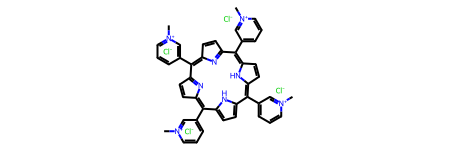

In [29]:
#visiualize a molecule randomly
random

In [164]:
top_10_research_subject = porph['Assay Description'].value_counts().head(10)


In [45]:

top_10_research_subject = porph['Assay Description'].value_counts().head(10)


def limit_words(description):
    return ' '.join(description.split()[:7])


top_10_table = pd.DataFrame({
    'Assay Description': top_10_research_subject.index,
    'Count': top_10_research_subject.values
})


top_10_table['Assay Description'] = top_10_table['Assay Description'].apply(limit_words)


print(top_10_table)

                                   Assay Description  Count
0        Cytotoxicity against human HCT116 cell line     17
1  Phototoxicity against human A549 cells assesse...     11
2  Phototoxicity against human ECA109 cells asses...      9
3  Photosensitizing activity against human HeLa c...      9
4  Cytotoxicity in rat R3230AC cells irradiated with      7
5         Dark toxicity in human A549 cells assessed      7
6           Dark toxicity in human HepG2 cells after      6
7  Phototoxicity against human HaCaT cells assess...      6
8  Cytotoxicity against human Bel7402 cells after 48      6
9  Antileishmanial activity against promastigote ...      6


In [46]:
top_3_values = porph['Standard Type'].value_counts().head(3)
top_3_values

Standard Type
IC50    317
Name: count, dtype: int64

# Frequency of assays

In [31]:
# Function of the most frequently worked structure
def freq(struc):
    col_list =  Counter(list(struc['Molecule ChEMBL ID']))
    res = dict(sorted(col_list.items(), key = itemgetter(1), reverse = True)[:7])
    return res
freq(porph)

{'CHEMBL65606': 7,
 'CHEMBL500576': 6,
 'CHEMBL1956500': 5,
 'CHEMBL1325592': 5,
 'CHEMBL2170855': 4,
 'CHEMBL207155': 3,
 'CHEMBL353314': 3}

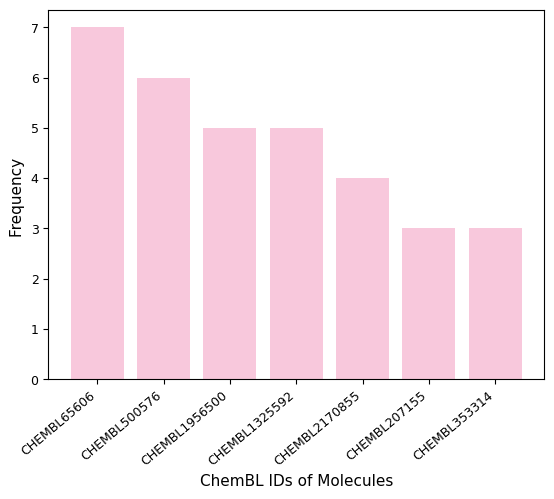

In [32]:
x=plt.bar(range(len(freq(porph))), list(freq(porph).values()), align='center',color ="#F8C8DC")
plt.xticks(range(len(freq(porph))), freq(porph).keys()) 
plt.xticks(rotation=40,fontsize='9',horizontalalignment='right')
plt.yticks(fontsize='9')
plt.xlabel('ChemBL IDs of Molecules',  color='black',
   fontsize='11', horizontalalignment='center')
plt.ylabel('Frequency ',  color='black',
   fontsize='11', horizontalalignment='center')
plt.grid(False);

In [33]:
freq_data = freq(porph)
keys = list(freq_data.keys())[:2]
smiles_list = list(porph.loc[porph['Molecule ChEMBL ID'].isin(keys), 'Smiles'])

# Molekülleri çizme
molecules = [Chem.MolFromSmiles(smiles) for smiles in smiles_list]
img = Draw.MolsToGridImage(molecules[0:2], molsPerRow=2, subImgSize=(200, 200))

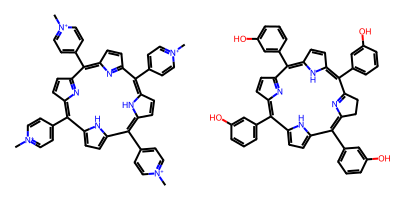

In [726]:
img

# Activity

In [ ]:
# IC50>10000 nM accepted as non-active

In [22]:
# assume Standard Value==0 as inactive
porph['Standard Value'] = porph['Standard Value'].fillna(10001)
porph=porph.dropna(subset=['Standard Value'])

In [23]:
# Labelling structures as active or non-active (Deep Learning Approach for Discovery of In Silico Drugs for Combating COVID-19)
rating = []
for row in porph["Standard Value"]:
    if row >= 10000 :    rating.append("pIC$_5$$_0$ inactive") 
    elif row < 10000:   rating.append("pIC$_5$$_0$ active")
    else:  rating.append("pIC$_5$$_0$ inactive")


In [24]:
# Assign active molecules
porph['activity_status'] = rating
porph[0:3]

,index,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,...,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value,activity_status
0,16,CHEMBL268410,NaN,NaN,1279.63,NaN,NaN,7,CC1=C(C(COC(=O)C23C[C@H]4C[C@@H](C2)C[C@@H](C3...,IC50,...,CHEMBL1126254,1.00,Scientific Literature,J Med Chem,1992.00,NaN,NaN,NaN,NaN,pIC$_5$$_0$ active
1,39,CHEMBL4741802,NaN,NaN,813.95,3.00,7.97,3a,CCCCCCOC(C)c1c(C)c2cc3nc(c(CC(=O)N[C@@H](CC(=O...,IC50,...,CHEMBL4706542,1.00,Scientific Literature,Eur J Med Chem,2020.00,CHEMBL3307651,TIME = 48.0 hr,NaN,NaN,pIC$_5$$_0$ inactive
2,40,CHEMBL2111186,TALAPORFIN,3.00,711.77,3.00,5.95,Talaporfin,C=Cc1c(C)c2cc3nc(c(CC(=O)N[C@@H](CC(=O)O)C(=O)...,IC50,...,CHEMBL4706542,1.00,Scientific Literature,Eur J Med Chem,2020.00,CHEMBL3307762,TIME = 48.0 hr,NaN,NaN,pIC$_5$$_0$ inactive


# pIC50 calculation of Compounds

In [123]:
result = []
for value in porph['Standard Value']:
    if value < 0:
        solution_log=0
    elif value==0 : 
        solution_log=0
    elif value=='': 
        solution_log=0
    else:
        solution_log=round(math.log(value*(10**-9),10)*-1,2)
    result.append(solution_log)   
    
porph["pIC$_5$$_0$"]= result
porph[0:3]


,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type,Standard Text Value,pIC$_5$$_0$
0,CHEMBL1325592,PROTOPORPHYRIN,-1.00,562.67,2.00,7.50,SID50106857,C=CC1=C(C)c2cc3[nH]c(cc4nc(cc5[nH]c(cc1n2)c(C)...,Potency,'=',...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.00
1,CHEMBL441738,AFAMELANOTIDE,4.00,1646.87,NaN,NaN,NDP-MSH,CCCC[C@H](NC(=O)[C@H](CO)NC(=O)[C@H](Cc1ccc(O)...,EC50,'=',...,CHEMBL1136069,1.00,Scientific Literature,Bioorg Med Chem Lett,2003.00,CHEMBL3307715,NaN,NaN,NaN,7.92
2,CHEMBL441738,AFAMELANOTIDE,4.00,1646.87,NaN,NaN,NDP-MSH,CCCC[C@H](NC(=O)[C@H](CO)NC(=O)[C@H](Cc1ccc(O)...,EC50,'=',...,CHEMBL1136069,1.00,Scientific Literature,Bioorg Med Chem Lett,2003.00,CHEMBL3307715,NaN,NaN,NaN,7.12


In [26]:
# pIC50 z-score calculation
porph['z_score'] = stats.zscore(porph['pIC$_5$$_0$'])
porph_cleaned = porph[(porph['z_score'] < 3) & (porph['z_score'] > -3)]
porph_cleaned.reset_index(drop=True, inplace=True)

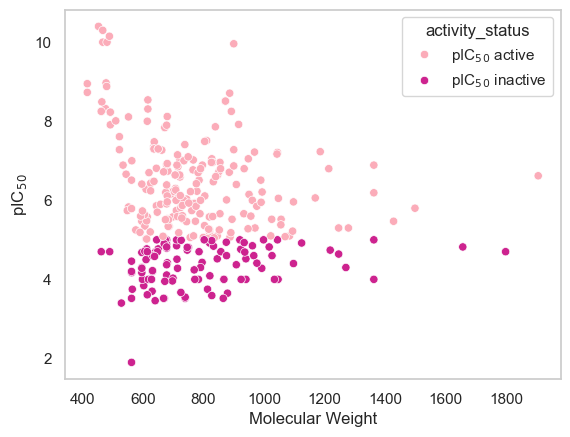

In [581]:
sns.scatterplot(x='Molecular Weight',y='pIC$_5$$_0$',hue='activity_status', data=porph,palette="RdPu")
sns.color_palette("mako", as_cmap=True)
plt.grid(False);

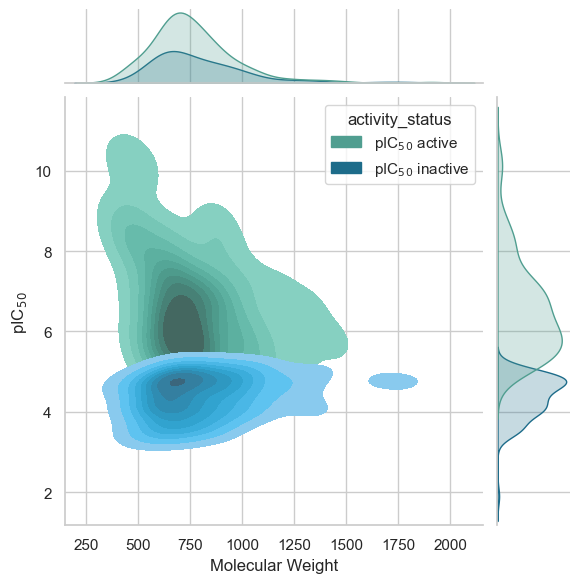

In [582]:
sns.jointplot(
    x='Molecular Weight', 
    y='pIC$_5$$_0$', 
    hue='activity_status', 
    data=porph, 
    palette="crest", 
    kind="kde", 
    fill=True
    
);

''

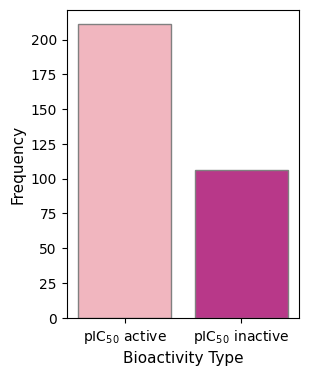

In [67]:
plt.figure(figsize=(3,4))
sns.countplot(x='activity_status', data=porph, palette="RdPu", edgecolor='grey')
plt.xlabel('Bioactivity Type', fontsize=11)
plt.ylabel('Frequency', fontsize=11)
plt.grid(False)
plt.savefig('ratio_active.png', dpi=600)
;

In [104]:
percentage = (porph['activity'] == "1").mean() * 100
print(f"Percentage of 'activity' == 1: {percentage:.2f}%")


Percentage of 'activity' == 1: 66.56%


In [105]:
count = porph['activity'].eq("1").sum()
print(f"Count of 'activity' == '1': {count}")

Count of 'activity' == '1': 211


In [487]:
percentage = (porph['activity_status'] == "pIC$_5$$_0$ active").mean() * 100
print(f"Percentage of 'activity' == 1: {percentage:.2f}%") 

Percentage of 'activity' == 1: 66.56%


In [492]:
percentage = (porph['activity_status'] == "pIC$_5$$_0$ inactive").mean() * 100
print(f"Percentage of 'activity' == 1: {percentage:.2f}%") 

Percentage of 'activity' == 1: 33.44%


In [495]:
count_ = porph['activity_status'].eq("pIC$_5$$_0$ inactive").sum()
print(f"Count of 'activity' == 'pIC$_5$$_0$ inactive': {count_}")

Count of 'activity' == 'pIC$_5$$_0$ inactive': 106


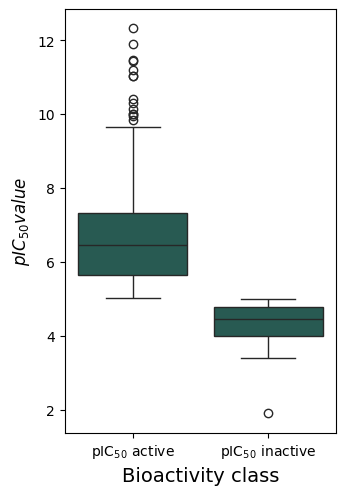

In [27]:
plt.figure(figsize=(3.5, 5.5))
sns.boxplot(x = 'activity_status', y = 'pIC$_5$$_0$', data = porph, color="#1f6357")
plt.xlabel('Bioactivity class', fontsize=14)
plt.ylabel("$pIC_{50} value$", fontsize=12, fontweight='bold');

# Lipinski Rule of Five

In [27]:
def calculate_ro5_properties(smiles):
    """
    Test if input molecule (SMILES) fulfills Lipinski's rule of five.

    Parameters
    ----------
    smiles : str
        SMILES for a molecule.

    Returns
    -------
    pandas.Series
        Molecular weight, number of hydrogen bond acceptors/donor and logP value
        and Lipinski's rule of five compliance for input molecule.
    """
    # RDKit molecule from SMILES
    molecule = Chem.MolFromSmiles(smiles)
    # Calculate Ro5-relevant chemical properties
    molecular_weight = Descriptors.ExactMolWt(molecule)
    n_hba = Descriptors.NumHAcceptors(molecule)
    n_hbd = Descriptors.NumHDonors(molecule)
    logp = Descriptors.MolLogP(molecule)
    # Check if Ro5 conditions fulfilled
    conditions = [molecular_weight <= 500, n_hba <= 10, n_hbd <= 5, logp <= 5]
    ro5_fulfilled = sum(conditions) >= 3
    # Return True if no more than one out of four conditions is violated
    return pd.Series(
        [molecular_weight, n_hba, n_hbd, logp, ro5_fulfilled],
        index=["molecular_weight", "n_hba", "n_hbd", "logp", "ro5_fulfilled"],
    )